## Anat Notebook


## imports

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from code.features import has_feature
import numpy as np
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

## Import data sets needed as housing_df

In [99]:
housing_df = pd.read_csv('data/kc_house_data.csv')
housing_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000,30155.00000
mean,4538103795.02689,1108535.83787,3.41353,2.33474,2112.42474,16723.59592,1.54349,1809.82610,476.03940,330.21114,217.41204,1975.16395,90.92230,47.32808,-121.31740
std,2882587298.12350,896385.65919,0.98161,0.88956,974.04432,60382.60402,0.56772,878.30613,579.63130,285.77054,245.30279,32.06736,416.47304,1.43400,5.72548
min,1000055.00000,27360.00000,0.00000,0.00000,3.00000,402.00000,1.00000,2.00000,0.00000,0.00000,0.00000,1900.00000,0.00000,21.27424,-157.79148
25%,2064175145.00000,648000.00000,3.00000,2.00000,1420.00000,4850.00000,1.00000,1180.00000,0.00000,0.00000,40.00000,1953.00000,0.00000,47.40532,-122.32604
50%,3874010800.00000,860000.00000,3.00000,2.50000,1920.00000,7480.00000,1.50000,1560.00000,0.00000,400.00000,150.00000,1977.00000,0.00000,47.55138,-122.22558
75%,7287100141.00000,1300000.00000,4.00000,3.00000,2619.50000,10579.00000,2.00000,2270.00000,940.00000,510.00000,320.00000,2003.00000,0.00000,47.66991,-122.11621
max,9904000012.00000,30750000.00000,13.00000,10.50000,15360.00000,3253932.00000,4.00000,12660.00000,8020.00000,3580.00000,4370.00000,2022.00000,2022.00000,64.82407,-70.07434


In [100]:
housing_df['zip'] = housing_df['address'].map(lambda x: x.split(',')[-2][-5:])
#this is getting all the zipcodes

### Importing zip codes from website (note here what was happening)

In [101]:
zip_codes = pd.read_csv('data/King_County_Zip_Codes.csv') #from king county database

Removing zip codes outside of kings county based on CSV (doing this by merge) 

In [102]:
kc_only = housing_df.merge(zip_codes['Zip Codes'].astype(str),left_on='zip',right_on='Zip Codes',how='inner')

In [103]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [104]:
kc_only.head(2) #checking out the dataset

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zip,Zip Codes
0,7399300360,5/24/2022,675000.00000,4,1.00000,1180,7140,1.00000,NO,NO,...,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.46198,-122.19052,98055,98055
1,3340401570,3/2/2022,750000.00000,3,2.00000,1830,7969,1.00000,NO,NO,...,930,240,90,1950,2008,"306 South 15th Street, Renton, Washington 9805...",47.46673,-122.21400,98055,98055


Creating dataframe for homes including: 
- Sqft living greater than 400 since below 400sqft is considered tiny home according to ...
- has bedrooms
- has bathrooms
- price is less than 5M since the average american is not buying homes in the 5M range
- dropping columns that will not be relevant such as lat, long, Zip Codes


In [107]:
homes_df = kc_only[(kc_only['sqft_living'] > 400) 
                   & (kc_only['bedrooms'] > 0) 
                   & (kc_only['bathrooms'] > 0) 
                   & (kc_only['price'] < 50000000)
].drop(['lat','long', 'Zip Codes', 'address', 'heat_source', 'grade', 'sewer_system', 'nuisance'],axis=1)
homes_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,view,condition,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,zip
0,7399300360,5/24/2022,675000.00000,4,1.00000,1180,7140,1.00000,NO,NO,NONE,Good,1180,0,0,40,1969,0,98055
1,3340401570,3/2/2022,750000.00000,3,2.00000,1830,7969,1.00000,NO,NO,NONE,Average,930,930,240,90,1950,2008,98055
2,7399301200,3/29/2022,728000.00000,4,2.00000,2170,7520,1.00000,NO,NO,NONE,Average,1240,1240,490,60,1973,0,98055
3,9899200050,3/24/2022,565000.00000,4,2.00000,1400,10364,1.50000,NO,NO,NONE,Good,1400,0,330,330,1971,0,98055
4,6673070070,12/28/2021,645000.00000,3,2.00000,1520,8250,1.00000,NO,NO,NONE,Average,1190,590,420,200,1981,0,98055


#### to be removed 
- Dropping homes in zip code with less than 100 houses since deeming these unreliable  to the data #double check with daniel on this part.  [Has not been done yet]

#### Creating additional columns

In [108]:
homes_df[['has_basement', 'has_garage', 
          'has_patio', 'renovated']] = homes_df[['sqft_basement', 
        'sqft_garage', 'sqft_patio', 'yr_renovated']].apply(has_feature)

homes_df['sell_year'] = homes_df['date'].map(lambda x: x.split('/')[-1][-4:])
homes_df['sell_age'] = homes_df['sell_year'].astype(int) - homes_df['yr_built'].astype(int)


homes_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_patio,yr_built,yr_renovated,zip,has_basement,has_garage,has_patio,renovated,sell_year,sell_age
0,7399300360,5/24/2022,675000.00000,4,1.00000,1180,7140,1.00000,NO,NO,...,40,1969,0,98055,0,0,1,0,2022,53
1,3340401570,3/2/2022,750000.00000,3,2.00000,1830,7969,1.00000,NO,NO,...,90,1950,2008,98055,1,1,1,1,2022,72
2,7399301200,3/29/2022,728000.00000,4,2.00000,2170,7520,1.00000,NO,NO,...,60,1973,0,98055,1,1,1,0,2022,49
3,9899200050,3/24/2022,565000.00000,4,2.00000,1400,10364,1.50000,NO,NO,...,330,1971,0,98055,0,1,1,0,2022,51
4,6673070070,12/28/2021,645000.00000,3,2.00000,1520,8250,1.00000,NO,NO,...,200,1981,0,98055,1,1,1,0,2021,40


### Condition Variable
Transforming condition into numeric variable 0-4. We are ordinarly encoding this to make it a numeric variable from a category to a numeric and keeping the natural ordering system of: 
- Poor = 0
- Fair = 1
- Average = 2
- Good = 3
- Very Good = 4

In [109]:
homes_df['condition'].value_counts() #checking out what is in the condition column 

Average      17548
Good          8038
Very Good     3254
Fair           222
Poor            59
Name: condition, dtype: int64

In [110]:
#creating its own dataframe for simplicity 
condition_df = pd.DataFrame(homes_df['condition'])
condition_df 

,condition
0,Good
1,Average
2,Average
3,Good
4,Average
...,...
29184,Very Good
29185,Average
29186,Fair
29187,Average


In [111]:
categories = [['Poor', 'Fair', 'Average', 'Good', 'Very Good']]
ords = OrdinalEncoder(categories=categories)
ords.fit(condition_df)
condition_df['condition'] = ords.transform(condition_df)
condition_df

,condition
0,3.00000
1,2.00000
2,2.00000
3,3.00000
4,2.00000
...,...
29184,4.00000
29185,2.00000
29186,1.00000
29187,2.00000


In [112]:
homes_df['condition_numeric'] = condition_df['condition']
homes_df.head() #checking out new column

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,yr_built,yr_renovated,zip,has_basement,has_garage,has_patio,renovated,sell_year,sell_age,condition_numeric
0,7399300360,5/24/2022,675000.00000,4,1.00000,1180,7140,1.00000,NO,NO,...,1969,0,98055,0,0,1,0,2022,53,3.00000
1,3340401570,3/2/2022,750000.00000,3,2.00000,1830,7969,1.00000,NO,NO,...,1950,2008,98055,1,1,1,1,2022,72,2.00000
2,7399301200,3/29/2022,728000.00000,4,2.00000,2170,7520,1.00000,NO,NO,...,1973,0,98055,1,1,1,0,2022,49,2.00000
3,9899200050,3/24/2022,565000.00000,4,2.00000,1400,10364,1.50000,NO,NO,...,1971,0,98055,0,1,1,0,2022,51,3.00000
4,6673070070,12/28/2021,645000.00000,3,2.00000,1520,8250,1.00000,NO,NO,...,1981,0,98055,1,1,1,0,2021,40,2.00000


In [113]:
homes_df.info()
#numeric: price, bedrooms, bathrooms, sqft_living, sqft_lot, floors,  
#sqft_above,  sqft_basement, sqft_garage  , sqft_patio, yr_built, yr_renovated   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29121 entries, 0 to 29188
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 29121 non-null  int64  
 1   date               29121 non-null  object 
 2   price              29121 non-null  float64
 3   bedrooms           29121 non-null  int64  
 4   bathrooms          29121 non-null  float64
 5   sqft_living        29121 non-null  int64  
 6   sqft_lot           29121 non-null  int64  
 7   floors             29121 non-null  float64
 8   waterfront         29121 non-null  object 
 9   greenbelt          29121 non-null  object 
 10  view               29121 non-null  object 
 11  condition          29121 non-null  object 
 12  sqft_above         29121 non-null  int64  
 13  sqft_basement      29121 non-null  int64  
 14  sqft_garage        29121 non-null  int64  
 15  sqft_patio         29121 non-null  int64  
 16  yr_built           291

In [123]:
numeric_homes = homes_df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',  'has_patio', 'has_garage', 
                          'has_basement', 'sell_age','renovated', 'condition_numeric']]   

In [131]:
numeric_homes

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,has_patio,has_garage,has_basement,sell_age,renovated,condition_numeric
0,675000.00000,4,1.00000,1180,7140,1.00000,1,0,0,53,0,3.00000
1,750000.00000,3,2.00000,1830,7969,1.00000,1,1,1,72,1,2.00000
2,728000.00000,4,2.00000,2170,7520,1.00000,1,1,1,49,0,2.00000
3,565000.00000,4,2.00000,1400,10364,1.50000,1,1,0,51,0,3.00000
4,645000.00000,3,2.00000,1520,8250,1.00000,1,1,1,40,0,2.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
29184,750000.00000,3,1.00000,1530,33250,1.50000,1,0,1,117,0,4.00000
29185,315000.00000,1,1.00000,480,7475,1.00000,0,0,0,113,1,2.00000
29186,250000.00000,2,1.00000,1040,114998,1.00000,0,0,0,93,0,1.00000
29187,202000.00000,2,1.00000,1260,11160,1.50000,1,0,0,103,0,2.00000


Dropping unnecessary columns for the purposes of our exploration: Address, Waterfront, 

In [116]:
homes_df.corr() ##looking for most correlated variable to our y which is price

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,has_basement,has_garage,has_patio,renovated,sell_age,condition_numeric
id,1.00000,-0.02956,-0.00509,-0.01177,-0.02762,-0.12071,0.03495,-0.02238,-0.01504,-0.00727,-0.04253,0.02282,-0.02973,0.00561,0.03432,0.00174,-0.02973,-0.02294,-0.00917
price,-0.02956,1.00000,0.29563,0.49200,0.62076,0.08453,0.20181,0.54955,0.24735,0.26928,0.31874,0.10741,0.08602,0.10715,0.11196,0.15247,0.08574,-0.10630,-0.01393
bedrooms,-0.00509,0.29563,1.00000,0.59105,0.63218,-0.00006,0.20016,0.53914,0.23366,0.30327,0.18932,0.18516,0.01033,0.07985,0.22368,0.17068,0.01007,-0.18552,0.01587
bathrooms,-0.01177,0.49200,0.59105,1.00000,0.78210,0.03759,0.43307,0.68332,0.25964,0.46109,0.33217,0.45903,0.04201,0.12299,0.33912,0.28772,0.04158,-0.45948,-0.06860
sqft_living,-0.02762,0.62076,0.63218,0.78210,1.00000,0.11895,0.35689,0.88151,0.33415,0.50373,0.40507,0.32992,0.03545,0.10139,0.29246,0.27544,0.03526,-0.33024,-0.07065
sqft_lot,-0.12071,0.08453,-0.00006,0.03759,0.11895,1.00000,-0.02014,0.12885,0.00291,0.08457,0.16027,0.01299,0.00871,-0.04192,-0.01973,0.03173,0.00875,-0.01308,-0.00429
floors,0.03495,0.20181,0.20016,0.43307,0.35689,-0.02014,1.00000,0.50628,-0.24393,0.18153,0.12440,0.52089,-0.01533,-0.19116,0.14285,0.20573,-0.01529,-0.52092,-0.26651
sqft_above,-0.02238,0.54955,0.53914,0.68332,0.88151,0.12885,0.50628,1.00000,-0.07601,0.55412,0.32000,0.42908,0.00725,-0.25005,0.32994,0.23927,0.00723,-0.42926,-0.15440
sqft_basement,-0.01504,0.24735,0.23366,0.25964,0.33415,0.00291,-0.24393,-0.07601,1.00000,0.01590,0.21384,-0.22747,0.05236,0.85299,-0.00497,0.11714,0.05223,0.22721,0.08961
sqft_garage,-0.00727,0.26928,0.30327,0.46109,0.50373,0.08457,0.18153,0.55412,0.01590,1.00000,0.22693,0.49768,-0.10484,-0.14955,0.81291,0.17355,-0.10508,-0.49766,-0.08601


<AxesSubplot:>

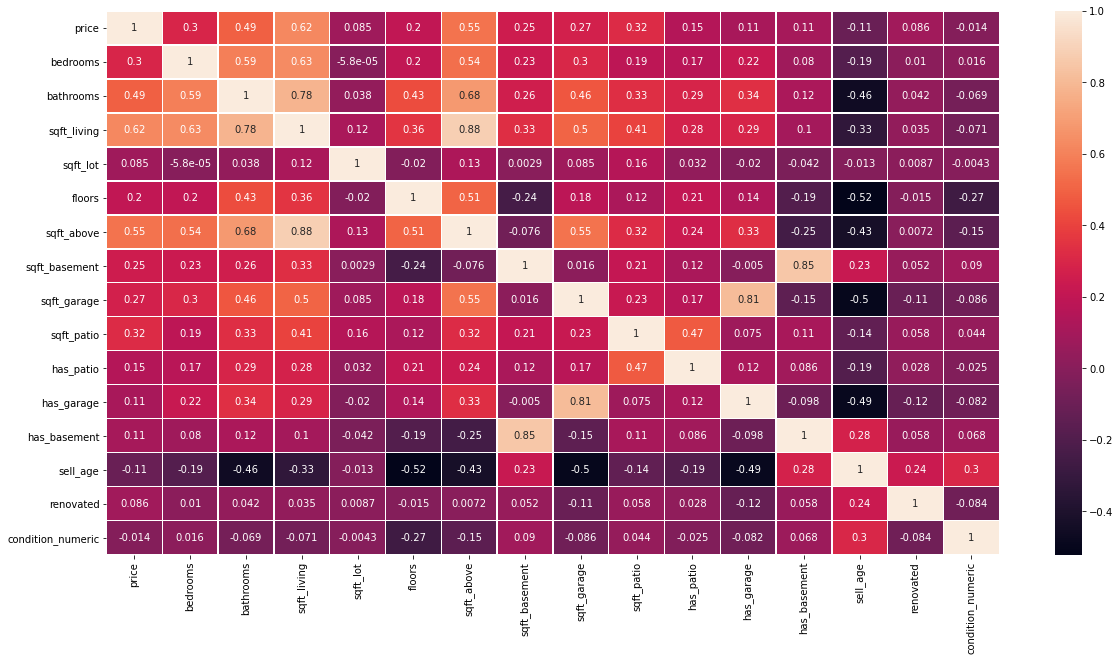

In [117]:
#heatmaps with correlation

plt.figure(figsize = (20,10))
sns.heatmap(numeric_homes.corr(), annot = True, linewidths=.5)


##

# Running simple regression based on most correlated variable of sqft_living

In [119]:
#run a simple regression on this correlation
x = homes_df['sqft_living']
y = homes_df['price']
simple_model = sm.OLS(y, sm.add_constant(x)).fit()
sm_summary = simple_model.summary()
sm_summary #shows a low rquared at .385 but model is significant. for every 1 sqft change, price increases by 568

#note kurtosis is 205 in this which denotes a very high skew. We therefore looked into taking the log instead of the uy variable. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                 1.826e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:49:51   Log-Likelihood:            -4.3326e+05
No. Observations:               29121   AIC:                         8.665e+05
Df Residuals:                   29119   BIC:                         8.665e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.933e+04   9866.861    -10.068      0.000   -1.19e+05      -8e+04
sqft_living   568.2131      4.206    135.111      0.000     559.970     576.456
==============================================================================
Omnibus:                    41926.772   Durbin-Watson:                   1.289
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50304374.618
Skew:                           8.140   Prob(JB):                         0.00
Kurtosis:                     205.961   Cond. No.                     5.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

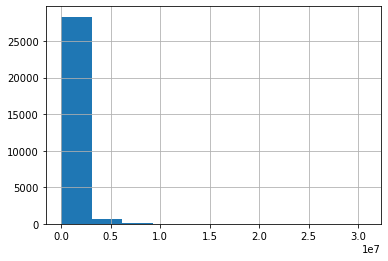

In [118]:
y.hist() #looking at skew. Deciding to take the log to help with assumptions. 

<AxesSubplot:>

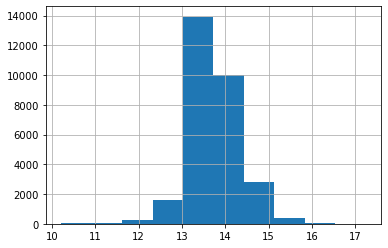

In [120]:
y_log = np.log(y)
y_log.hist()

In [121]:
#much more normal distribution so will be using the log of y for our dependent variable
y_log = np.log(y)
sm_log_model = sm.OLS(y_log, sm.add_constant(x)).fit()
sm_log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                 1.875e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:50:29   Log-Likelihood:                -18489.
No. Observations:               29121   AIC:                         3.698e+04
Df Residuals:                   29119   BIC:                         3.700e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9373      0.006   2010.503      0.000      12.925      12.950
sqft_living     0.0004   2.74e-06    136.919      0.000       0.000       0.000
==============================================================================
Omnibus:                     5900.747   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44702.235
Skew:                          -0.773   Prob(JB):                         0.00
Kurtosis:                       8.870   Cond. No.                     5.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
#looking at model of all numeric variables within dataset
x2 = numeric_homes.drop(['price'], axis = 1)
y_log = numeric_homes['price']
model = sm.OLS(y_log, sm.add_constant(x2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1922.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:55:13   Log-Likelihood:            -4.3240e+05
No. Observations:               29121   AIC:                         8.648e+05
Df Residuals:                   29109   BIC:                         8.649e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.324e+05   2.91e+04     -4.551      0.000   -1.89e+05   -7.54e+04
bedrooms          -1.716e+05   5501.322    -31.201      0.000   -1.82e+05   -1.61e+05
bathrooms          1.335e+05   8281.329     16.123      0.000    1.17e+05     1.5e+05
sqft_living         625.2045      7.135     87.624      0.000     611.219     639.190
sqft_lot              0.0031      0.067      0.046      0.963      -0.128       0.134
floors             2.512e+04   9306.409      2.699      0.007    6875.269    4.34e+04
has_patio          -3.89e+04   1.01e+04     -3.849      0.000   -5.87e+04   -1.91e+04
has_garage        -4.569e+04   1.02e+04     -4.494      0.000   -6.56e+04   -2.58e+04
has_basement       1025.0171   8885.853      0.115      0.908   -1.64e+04    1.84e+04
sell_age           3639.8480    195.535     18.615      0.000    3256.591    4023.105
renovated          1.096e+05   2.02e+04      5.433      0.000    7.01e+04    1.49e+05
condition_numeric  1.394e+04   6141.809      2.270      0.023    1906.244     2.6e+04
==============================================================================
Omnibus:                    41900.623   Durbin-Watson:                   1.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         52942345.384
Skew:                           8.107   Prob(JB):                         0.00
Kurtosis:                     211.253   Cond. No.                     4.78e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that the has basement and sqft_lot both are statistically insignificant and will remove the two and rerun. 

In [128]:
x3 = numeric_homes.drop(['price', 'has_basement', 'sqft_lot'], axis = 1)
y_log = np.log(y)
log_model2 = sm.OLS(y_log, sm.add_constant(x3)).fit()
log_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     2338.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:55:22   Log-Likelihood:                -17806.
No. Observations:               29121   AIC:                         3.563e+04
Df Residuals:                   29111   BIC:                         3.571e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.5784      0.019    662.246      0.000      12.541      12.616
bedrooms             -0.0659      0.004    -18.332      0.000      -0.073      -0.059
bathrooms             0.0965      0.005     18.287      0.000       0.086       0.107
sqft_living           0.0004   4.62e-06     76.630      0.000       0.000       0.000
floors                0.0955      0.006     15.877      0.000       0.084       0.107
has_patio             0.0318      0.007      4.825      0.000       0.019       0.045
has_garage            0.0236      0.007      3.545      0.000       0.011       0.037
sell_age              0.0029      0.000     23.316      0.000       0.003       0.003
renovated             0.0546      0.013      4.138      0.000       0.029       0.081
condition_numeric     0.0333      0.004      8.293      0.000       0.025       0.041
==============================================================================
Omnibus:                     6572.396   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56268.849
Skew:                          -0.847   Prob(JB):                         0.00
Kurtosis:                       9.596   Cond. No.                     1.76e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
x4 = numeric_homes[['renovated', 'sell_age','sqft_living']]
y_log = numeric_homes['price']
multi_model = sm.OLS(y_log, sm.add_constant(x4)).fit()
mm_summary = multi_model.summary()
mm_summary #this is a lower adj R,

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     6408.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:56:28   Log-Likelihood:            -4.3296e+05
No. Observations:               29121   AIC:                         8.659e+05
Df Residuals:                   29117   BIC:                         8.660e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.026e+05   1.38e+04    -21.899      0.000    -3.3e+05   -2.75e+05
renovated    1.645e+05   1.99e+04      8.258      0.000    1.25e+05    2.04e+05
sell_age     2815.1056    140.842     19.988      0.000    2539.049    3091.162
sqft_living   597.1450      4.445    134.339      0.000     588.432     605.858
==============================================================================
Omnibus:                    42131.746   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         53193399.707
Skew:                           8.203   Prob(JB):                         0.00
Kurtosis:                     211.734   Cond. No.                     1.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is a higher adjusted R squared when looking at the numeric variables given in the dataset. Based on this there are a few things to note:
1. sqft of lot has a p value greater than alpha at .5 and seems insignificant, bc of this we will be removing this from the regression

In [130]:

x = numeric_homes.drop(['price'], axis = 1)
ss = StandardScaler().fit(x)

X_scaled = ss.transform(x)
X_c = sm.add_constant(X_scaled)
scale_model = sm.OLS(endog=y_log, exog=X_c).fit()
scale_model.summary()
##this does nothing except lower covariance


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1922.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        13:57:26   Log-Likelihood:            -4.3240e+05
No. Observations:               29121   AIC:                         8.648e+05
Df Residuals:                   29109   BIC:                         8.649e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.113e+06   3983.487    279.426      0.000    1.11e+06    1.12e+06
x1         -1.663e+05   5329.350    -31.201      0.000   -1.77e+05   -1.56e+05
x2          1.192e+05   7393.313     16.123      0.000    1.05e+05    1.34e+05
x3          6.099e+05   6960.373     87.624      0.000    5.96e+05    6.24e+05
x4           186.3564   4063.371      0.046      0.963   -7778.035    8150.748
x5          1.375e+04   5093.689      2.699      0.007    3763.050    2.37e+04
x6         -1.627e+04   4225.600     -3.849      0.000   -2.45e+04   -7982.772
x7         -2.136e+04   4753.550     -4.494      0.000   -3.07e+04    -1.2e+04
x8           512.1566   4439.876      0.115      0.908   -8190.202    9214.515
x9          1.153e+05   6194.255     18.615      0.000    1.03e+05    1.27e+05
x10         2.319e+04   4268.585      5.433      0.000    1.48e+04    3.16e+04
x11         9867.4839   4346.111      2.270      0.023    1348.910    1.84e+04
==============================================================================
Omnibus:                    41900.623   Durbin-Watson:                   1.363
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         52942345.384
Skew:                           8.107   Prob(JB):                         0.00
Kurtosis:                     211.253   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#look into non renovated age homes specific data subset i.e where renovated = 0 
#look into other things too 
#booleans -- use the boolean columns instead of sqft columns in regression and check it out. 